In [0]:
slides_html="""

<iframe src="https://docs.google.com/presentation/d/1yR3oBKg8vvwKjvj4WWezf5ygJweo8rWuklD7IF4uVX0/embed?start=true&loop=true&delayms=4000" frameborder="0" width="900" height="560" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>
"""
displayHTML(slides_html)

# Spark OCR in Healthcare

Spark OCR is a commercial extension of Spark NLP for optical character recognition from images, scanned PDF documents, Microsoft DOCX and DICOM files. 

In this notebook we will:
  - Parsing the Files through OCR.
  - Extract PHI entites from extracted texts.
  - Hide PHI entites and get an obfucated versions of pdf files.
  - Hide PHI entities on original image.
  - Extract text from some Dicom images.
  - Hide PHI entities on Dicom images.

In [0]:
import os
import json
import string
#import sys
#import base64
import numpy as np
import pandas as pd

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from sparknlp.training import CoNLL

import matplotlib.pyplot as plt

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

spark.sql("set spark.sql.legacy.allowUntypedScalaUDF=true")

print('sparknlp.version : ',sparknlp.version())
print('sparknlp_jsl.version : ',sparknlp_jsl.version())
print('sparkocr : ',sparkocr.version())

spark

sparknlp.version : 3.1.0
sparknlp_jsl.version : 3.1.1
sparkocr : 3.4.0
Out[2]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 spark://10.164.240.250:7077 
 AppName 
 Databricks Shell

**Reading PDF files **

If you have large datasets, you can take your data into delta table and read from there to create a dataframe by using this script:  

```
pdfs = spark.read.format("delta").load("/mnt/delta/ocr_samples")

print("Number of files in the folder : ", pdfs.count())

```

In [0]:
%sh
for i in {0..3}
do
  wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/data/ocr/MT_OCR_0$i.pdf -P /dbfs/FileStore/HLS/nlp/
done

In [0]:
file_path='dbfs:/FileStore/HLS/nlp/'
pdfs = spark.read.format("binaryFile").load(f'{file_path}MT_OCR*.pdf').sort('path')
print("Number of files in the folder : ", pdfs.count())

Number of files in the folder : 3

In [0]:
display(pdfs)

path,modificationTime,length,content
dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,2021-07-14T11:03:56.000+0000,139028,JVBERi0xLjUKJafj8fEKMiAwIG9iago8PAovVHlwZSAvQ2F0YWxvZwovUGFnZXMgNCAwIFIKL0Fjcm9Gb3JtIDUgMCBSCi9WZXJzaW9uIC8xIzJFNQo+PgplbmRvYmoKOSAwIG9iago8PAovRmlsdGVyIC9GbGF0ZURlY29kZQo= (truncated)
dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf,2021-07-14T11:03:57.000+0000,165397,JVBERi0xLjMKJcTl8uXrp/Og0MTGCjMgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCAzNTMgPj4Kc3RyZWFtCngBpZO9TsQwDID3PoVfoD7bseNkhoWNm5hRdQikHnB38P64fzoQDK1olyixvnz+yQn2cAI= (truncated)
dbfs:/FileStore/HLS/nlp/MT_OCR_02.pdf,2021-07-14T11:03:58.000+0000,841095,JVBERi0xLjMKJcTl8uXrp/Og0MTGCjMgMCBvYmoKPDwgL0ZpbHRlciAvRmxhdGVEZWNvZGUgL0xlbmd0aCA4MyA+PgpzdHJlYW0KeAErVAhUKFQwAEJTS1MFCxMjhaJUhXCFPAX9gNSi5NSCktLEHIWiTLAakKyusYWRnrmRuTE= (truncated)


## 1. Parsing the Files through OCR

- The pdf files can have more than one page. We will transform the document in to images per page. Than we can run OCR to get text. 
- We are using `PdfToImage()` to render PDF to images and `ImageToText()` to runs OCR for each images.

In [0]:
# Transform PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

- Now, we can transform the `pdfs` with our pipeline.

In [0]:
ocr_result = ocr_pipeline.transform(pdfs)

- After transforming we get following columns :

  - path
  - modificationTime
  - length
  - image
  - total_pages
  - pagenum
  - documentnum
  - confidence
  - exception
  - text
  - positions

In [0]:
display(
  ocr_result.select('modificationTime', 'length', 'total_pages', 'pagenum', 'documentnum', 'confidence', 'exception')
)

modificationTime,length,total_pages,pagenum,documentnum,confidence,exception
2021-07-14T11:03:56.000+0000,139028,1,0,0,93.96357955932618,
2021-07-14T11:03:57.000+0000,165397,1,0,0,48.33505630493164,
2021-07-14T11:03:58.000+0000,841095,1,0,0,72.28577270507813,


In [0]:
display(ocr_result.select('path', 'image', 'text', 'positions'))

path,image,text,positions
dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,"List(dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf, 3249, 2250, 1, 10, 300, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))","Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma — 1 Record date : 2093-01-13 , David Hale, M.D., Name: Hendrickson , Ora MR. # 7194334 Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis.","List(List(List(List(Sample Type / Medical Specialty: Hematology - Oncology , 0, 265.0, 467.0, 605.0, 94.0, 10), List(Sample Name: Discharge Summary - Mesothelioma — 1 , 0, 265.0, 597.0, 713.0, 93.0, 10), List(Record date : 2093-01-13 , David Hale, M.D., , 0, 266.0, 757.0, 830.0, 38.0, 9), List(Name: Hendrickson , Ora MR. # 7194334 , 0, 266.0, 865.0, 752.0, 38.0, 9), List(Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) , 0, 266.0, 942.0, 1590.0, 202.0, 10), List(PRINCIPAL DIAGNOSIS: Mesothelioma. , 0, 266.0, 1183.0, 419.0, 81.0, 9), List(SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. , 0, 265.0, 1313.0, 1593.0, 137.0, 8), List(PROCEDURES 1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007, thoracentesis. 3. On August 31, 2007, Port-A-Cath placement. , 0, 264.0, 1495.0, 1514.0, 254.0, 10), List(HISTORY AND PHYSICAL: The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. , 0, 264.0, 1788.0, 1658.0, 306.0, 9), List(PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis. , 0, 265.0, 2134.0, 893.0, 513.0, 8))))"
dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf,"List(dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf, 3249, 2250, 1, 10, 300, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))","by Mr. ‘ on 3 7/10/68 C Sample Specifications written by John H. mM. Bohlken : ; - BLEND CASING . RECASING FINAL FLAVOR MENTHOL, FLAVOR OLD GOLD srRArcH? Tobacco Blend at

- Now, we have our pdf files in text format and as image. 

- Let's see the images and the text.

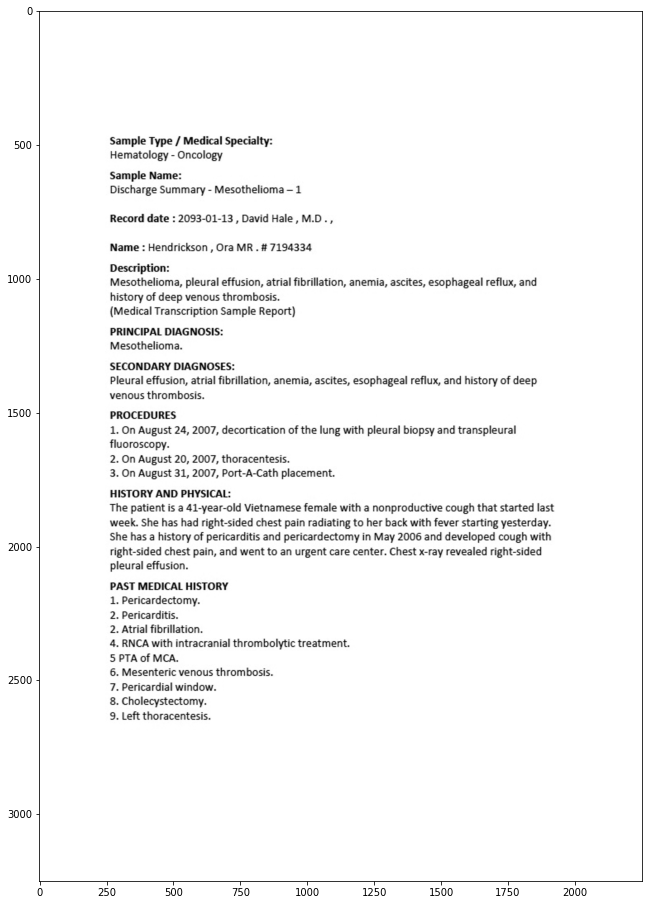

In [0]:
import matplotlib.pyplot as plt

img = ocr_result.collect()[0].image
img_pil = to_pil_image(img, img.mode)

plt.figure(figsize=(24,16))
plt.imshow(img_pil, cmap='gray')
plt.show()

- Let's see extracted text which is stored in `'text'` column as a list. Each line is is an item in this list, so we can join them and see the whole page.

In [0]:
print("\n".join([row.text for row in ocr_result.select("text").collect()[0:1]]))

Sample Type / Medical Specialty:
Hematology - Oncology

Sample Name:
Discharge Summary - Mesothelioma — 1

Record date : 2093-01-13 , David Hale, M.D.,

Name: Hendrickson , Ora MR. # 7194334

Description:

Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and
history of deep venous thrombosis.

(Medical Transcription Sample Report)

PRINCIPAL DIAGNOSIS:
Mesothelioma.

SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep
venous thrombosis.

PROCEDURES

1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural
fluoroscopy.

2. On August 20, 2007, thoracentesis.

3. On August 31, 2007, Port-A-Cath placement.

HISTORY AND PHYSICAL:

The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last
week. She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis and pericardectomy in May 2006 and developed cough with
right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided
pleural effusion.

PAST MEDICAL HISTORY

1. Pericardectomy.

2. Pericarditis.

2. Atrial fibrillation.

4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.

6. Mesenteric venous thrombosis.

7. Pericardial window.

8. Cholecystectomy.

9. Left thoracentesis.

### 1.1. Skew Correction

In some images, there may be some skewness and this reduces acuracy of the extracted text. Spark OCR has `ImageSkewCorrector` which detects skew of the image and rotates it.

In [0]:
# Image skew corrector 
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

skew_corrector = ImageSkewCorrector()\
      .setInputCol("image")\
      .setOutputCol("corrected_image")\
      .setAutomaticSkewCorrection(True)

ocr = ImageToText()\
      .setInputCol("corrected_image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_skew_corrected = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    ocr
])

In [0]:
ocr_skew_corrected_result = ocr_skew_corrected.transform(pdfs).cache()

Let's see the results after the skew correction.

In [0]:
display(ocr_result.filter(ocr_result.path==f"{file_path}MT_OCR_01.pdf").select('path', 'confidence'))

path,confidence
dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf,48.33505630493164


In [0]:
display(ocr_skew_corrected_result.filter(ocr_skew_corrected_result.path==f"{file_path}MT_OCR_01.pdf").select('path', 'confidence'))

path,confidence
dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf,66.58824359669404


After skew correction, confidence is increased from %48.3 to % %66.5. Let's display the corrected image and the original image side by side.

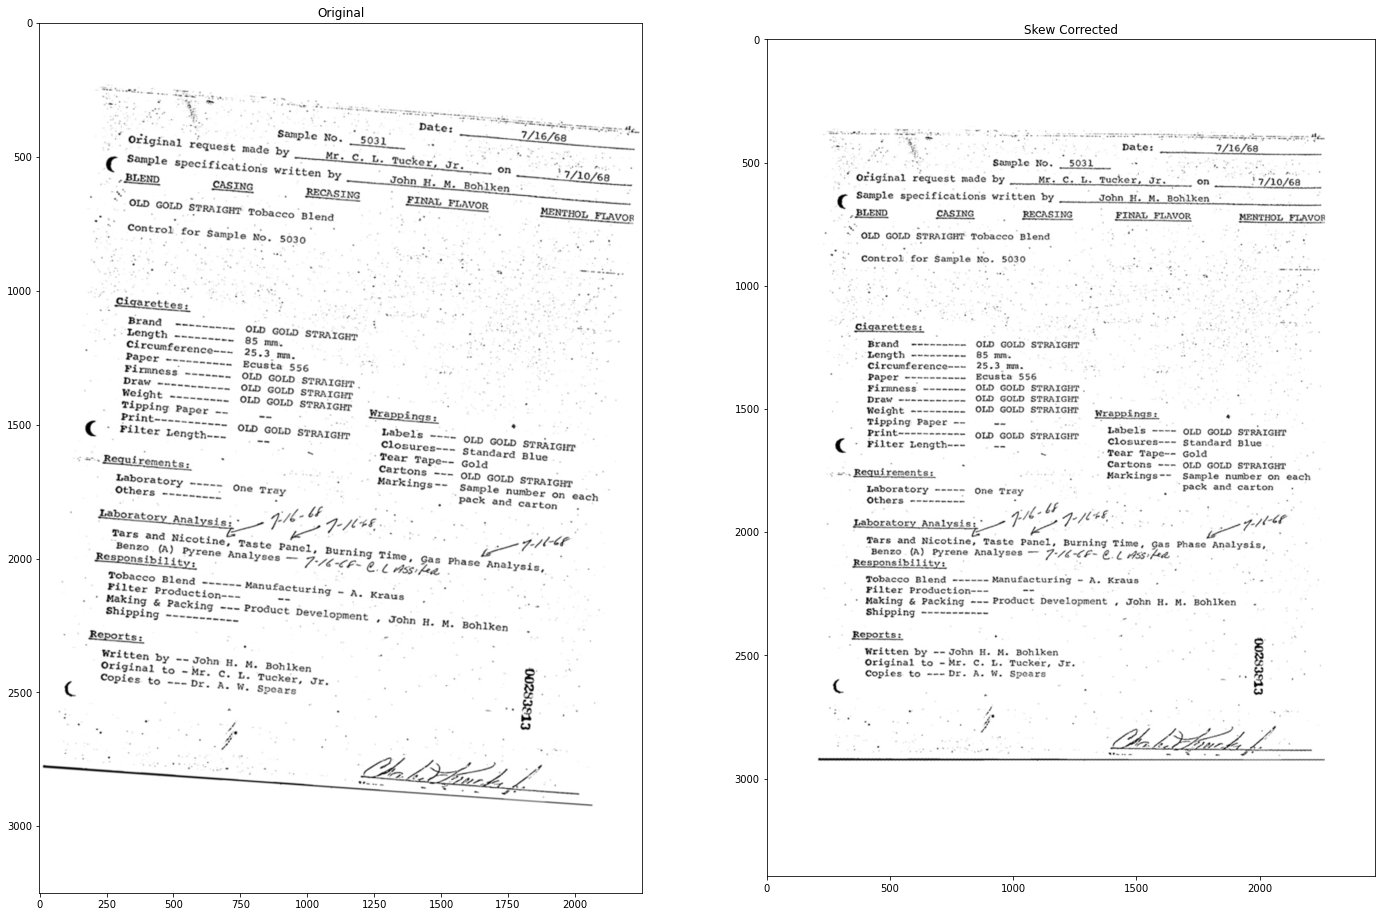

In [0]:
img_orig = ocr_skew_corrected_result.select("image").collect()[1].image
img_corrected = ocr_skew_corrected_result.select("corrected_image").collect()[1].corrected_image

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_corrected = to_pil_image(img_corrected, img_corrected.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_corrected, cmap='gray')
plt.title("Skew Corrected")
plt.show()

### 1.2. Image Processing

* After reading pdf files, we can process on images to increase the confidency.

* By **`ImageAdaptiveThresholding`**, we can compute a threshold mask image based on local pixel neighborhood and apply it to image. 

* Another method which we can add to pipeline is applying morphological operations. We can use **`ImageMorphologyOperation`** which support:
  - Erosion
  - Dilation
  - Opening
  - Closing   

* To remove remove background objects **`ImageRemoveObjects`** can be used.

* We will add **`ImageLayoutAnalyzer`** to pipeline, to analyze the image and determine the regions of text.

In [0]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(400)

# Correcting the skewness
skew_corrector = ImageSkewCorrector()\
      .setInputCol("image")\
      .setOutputCol("skew_corrected_image")\
      .setAutomaticSkewCorrection(True)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("skew_corrected_image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)


ocr_corrected = ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
  .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
  .setConfidenceThreshold(65)

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    binarizer,
    opening,
    remove_objects,
    ocr_corrected
])

In [0]:
result_processed = image_pipeline.transform(pdfs).cache()

Let's see the original image and corrected image.

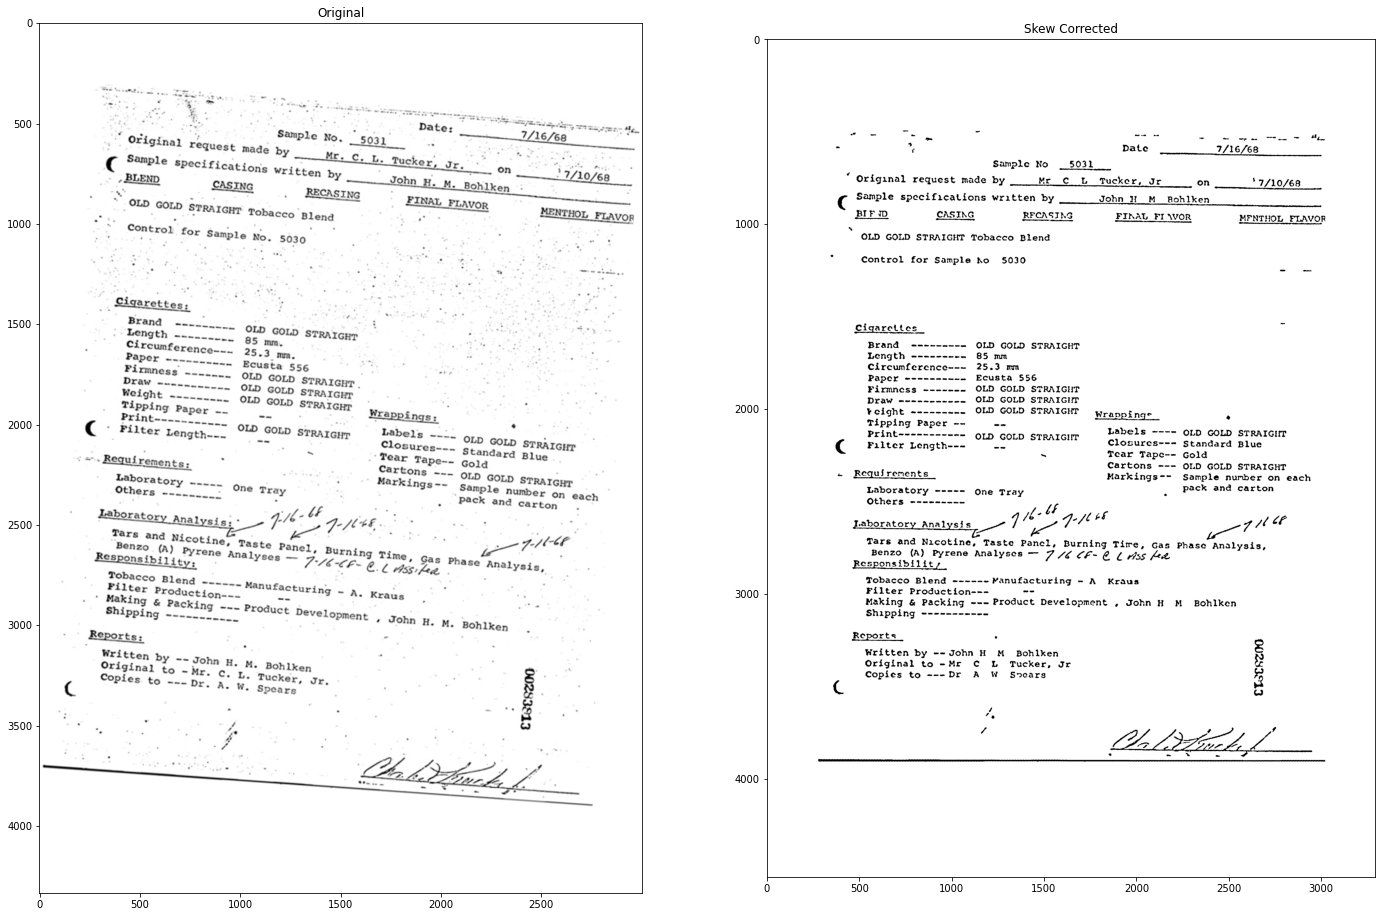

In [0]:
img_orig = result_processed.select("image").collect()[1].image
img_corrected = result_processed.select("corrected_image").collect()[1].corrected_image

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_corrected = to_pil_image(img_corrected, img_corrected.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_corrected, cmap='gray')
plt.title("Skew Corrected")
plt.show()

After processing, we have cleaner image. And confidence is increased to %97

In [0]:
print("Original Images")
display(ocr_result.filter(ocr_result.path==f"{file_path}MT_OCR_01.pdf").select('confidence'))

print("Skew Corrected Images")
display(ocr_skew_corrected_result.filter(ocr_skew_corrected_result.path==f"{file_path}MT_OCR_01.pdf").select('confidence'))

print("Corrected Images")
display(result_processed.filter(result_processed.path==f"{file_path}MT_OCR_01.pdf").select('confidence'))

Original Images

confidence
48.33505630493164


Skew Corrected Images

confidence
66.58824359669404


Corrected Images

confidence
97.74610498837964


## 2. Extracting the Clinical Entites

Now Let's create a clinical NER pipeline and see which entities we have. We will use `sentence_detector_dl_healthcare` to detect sentences and get entities by using [`ner_jsl`](https://nlp.johnsnowlabs.com/2021/06/24/ner_jsl_en.html) in `MedicalNerModel`.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[ | ][OK!]

In [0]:
ner_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter])

empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

In [0]:
ner_results = ner_model.transform(ocr_result)

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our ner_model.

In [0]:
sample_text = ocr_result.limit(2).select("text").collect()[0].text

In [0]:
print(sample_text)

Sample Type / Medical Specialty:
Hematology - Oncology

Sample Name:
Discharge Summary - Mesothelioma — 1

Record date : 2093-01-13 , David Hale, M.D.,

Name: Hendrickson , Ora MR. # 7194334

Description:

Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and
history of deep venous thrombosis.

(Medical Transcription Sample Report)

PRINCIPAL DIAGNOSIS:
Mesothelioma.

SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep
venous thrombosis.

PROCEDURES

1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural
fluoroscopy.

2. On August 20, 2007, thoracentesis.

3. On August 31, 2007, Port-A-Cath placement.

HISTORY AND PHYSICAL:

The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last
week. She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis and pericardectomy in May 2006 and developed cough with
right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided
pleural effusion.

PAST MEDICAL HISTORY

1. Pericardectomy.

2. Pericarditis.

2. Atrial fibrillation.

4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.

6. Mesenteric venous thrombosis.

7. Pericardial window.

8. Cholecystectomy.

9. Left thoracentesis.

In [0]:
light_model =  LightPipeline(ner_model)
 
ann_text = light_model.fullAnnotate(sample_text)[0]

`fullAnnotate` method returns the results as a dictionary. But the dictionary stored in a list. So we can reach to the dict by adding `[0]` to the end of the annotated text.

We can get some columns and transform them to a Pandas dataframe.

In [0]:
chunks = []
entities = []
sentence= []
begin = []
end = []

for n in ann_text['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)

Out[27]:

,chunks,begin,end,sentence_id,entities
0,Hematology,33,42,1,Clinical_Dept
1,Oncology,46,53,1,Clinical_Dept
2,Discharge,69,77,2,Admission_Discharge
3,Mesothelioma,89,100,2,Oncological
4,Ora MR,173,178,4,Test
5,Description:,192,203,6,Section_Header
6,Mesothelioma,206,217,7,Oncological
7,pleural effusion,220,235,7,Disease_Syndrome_Disorder
8,atrial fibrillation,238,256,7,Heart_Disease
9,anemia,259,264,7,Disease_Syndrome_Disorder


We can visualise the annotated text by `display` method of `NerVisualizer()`

In [0]:
from sparknlp_display import NerVisualizer
 
visualiser = NerVisualizer()

ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)
 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology Clinical_Dept - Oncology Clinical_Dept Sample Name: Discharge Admission_Discharge Summary - Mesothelioma Oncological — 1 Record date : 2093-01-13 , David Hale, M.D., Name: Hendrickson , Ora MR Test . # 7194334 Description: Section_Header Mesothelioma Oncological , pleural effusion Disease_Syndrome_Disorder , atrial fibrillation Heart_Disease , anemia Disease_Syndrome_Disorder , ascites Disease_Syndrome_Disorder , esophageal reflux Disease_Syndrome_Disorder , and history of deep venous thrombosis Disease_Syndrome_Disorder . (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Section_Header Mesothelioma Oncological . SECONDARY DIAGNOSES: Section_Header Pleural effusion Disease_Syndrome_Disorder , atrial fibrillation Heart_Disease , anemia Disease_Syndrome_Disorder , ascites Disease_Syndrome_Disorder , esophageal reflux Disease_Syndrome_Disorder , and history of deep venous thrombosis Disease_Syndrome_Disorder . PROCEDURES 1 Section_Header . On August 24, 2007 Date , decortication of the lung Procedure with pleural biopsy Procedure and transpleural fluoroscopy Procedure . 2. On August 20, 2007 Date , thoracentesis Procedure . 3. On August 31, 2007 Date , Port-A-Cath placement Procedure . HISTORY AND PHYSICAL: Section_Header The patient is a 41-year-old Age Vietnamese Race_Ethnicity female Gender with a nonproductive Modifier cough Symptom that started last week RelativeDate . She Gender has had right-sided Direction chest pain Symptom radiating Modifier to her Gender back External_body_part_or_region with fever VS_Finding starting yesterday RelativeDate . She Gender has a history of pericarditis Disease_Syndrome_Disorder and pericardectomy Procedure in May 2006 Date and developed cough Symptom with right-sided Direction chest pain Symptom , and went to an urgent care center Clinical_Dept . Chest x-ray Test revealed right-sided Direction pleural effusion Disease_Syndrome_Disorder . PAST MEDICAL HISTORY 1 Medical_History_Header . Pericardectomy Procedure . 2. Pericarditis Disease_Syndrome_Disorder . 2. Atrial fibrillation Heart_Disease . 4. RNCA with intracranial thrombolytic treatment Procedure . 5 PTA of MCA Procedure . 6. Mesenteric venous thrombosis Disease_Syndrome_Disorder . 7. Pericardial window Internal_organ_or_component . 8. Cholecystectomy Procedure . 9. Left Direction thoracentesis Procedure .

## 3. Extracting and Hiding the PHI Entities

In our documents we have some fields which we want to hide. To do it, we will use deidentification model. It identifies instances of protected health information in text documents, and it can either obfuscate them (e.g., replacing names with different, fake names) or mask them.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("corrected_text")\
  .setOutputCol("document")
 
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
  .setInputCols(["document"]) \
  .setOutputCol("sentence")
 
tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\
 
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
 
deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")
 
deid_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")
 
deid_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        deid_ner,
        deid_ner_converter])
 
empty_data = spark.createDataFrame([['']]).toDF("corrected_text")
deid_model = deid_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[ | ][OK!]

We created another pipeline which detects PHI entities. We will use the same text above and visualize again.

In [0]:
sample_text = ocr_result.limit(2).select("text").collect()[0].text
light_deid_model =  LightPipeline(deid_model)
 
ann_text = light_deid_model.fullAnnotate(sample_text)[0]

chunks = []
entities = []
sentence= []
begin = []
end = []

for n in ann_text['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})
				   
visualiser = NerVisualizer()

ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)
 
displayHTML(ner_vis)

Sample Type / Medical Specialty: Hematology - Oncology Sample Name: Discharge Summary - Mesothelioma — 1 Record date : 2093-01-13 DATE , David Hale NAME , M.D., Name: Hendrickson , Ora NAME MR. # 7194334 ID Description: Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. (Medical Transcription Sample Report) PRINCIPAL DIAGNOSIS: Mesothelioma. SECONDARY DIAGNOSES: Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis. PROCEDURES 1. On August 24, 2007 DATE , decortication of the lung with pleural biopsy and transpleural fluoroscopy. 2. On August 20, 2007 DATE , thoracentesis. 3. On August 31, 2007 DATE , Port-A-Cath placement. HISTORY AND PHYSICAL: The patient is a 41-year-old AGE Vietnamese LOCATION female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 DATE and developed cough with right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided pleural effusion. PAST MEDICAL HISTORY 1. Pericardectomy. 2. Pericarditis. 2. Atrial fibrillation. 4. RNCA with intracranial thrombolytic treatment. 5 PTA of MCA. 6. Mesenteric venous thrombosis. 7. Pericardial window. 8. Cholecystectomy. 9. Left thoracentesis.

In [0]:
# Transform PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("corrected_text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

obfuscation = DeIdentification()\
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("obfuscate")\
      .setObfuscateRefSource("faker")\
      .setObfuscateDate(True)

obfuscation_pipeline = Pipeline(stages=[
        pdf_to_image,
        ocr,
        deid_pipeline,
        obfuscation
    ])

In [0]:
from pyspark.sql.types import BinaryType

empty_data = spark.createDataFrame([['']]).toDF("path")
empty_data = empty_data.withColumn('content', empty_data.path.cast(BinaryType()))

obfuscation_model = obfuscation_pipeline.fit(empty_data)

In [0]:
obfuscation_result = obfuscation_model.transform(pdfs)

In [0]:
result_df = obfuscation_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ner_label"))

Let's count the number of entities we want to deidentificate and then see them.

In [0]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+----------+-----+
ner_label |count|
+----------+-----+
O |347 |
I-NAME |24 |
I-DATE |10 |
B-NAME |10 |
B-DATE |6 |
B-ID |1 |
B-AGE |1 |
B-LOCATION|1 |
+----------+-----+

In [0]:
obfuscation_result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+------------------+---------+
chunk |ner_label|
+------------------+---------+
2093-01-13 |DATE |
David Hale |NAME |
Hendrickson , Ora |NAME |
7194334 |ID |
August 24, 2007 |DATE |
August 20, 2007 |DATE |
August 31, 2007 |DATE |
41-year-old |AGE |
Vietnamese |LOCATION |
May 2006 |DATE |
‘ |NAME |
7/10/68 |DATE |
John H |NAME |
A. Kraus |NAME |
John H. M. Bohlken|NAME |
John H. M. Bohlken|NAME |
C. L. Tucker, Jr |NAME |
A |NAME |
W. Spears |NAME |
+------------------+---------+

In deidentified column, entities like date and name are replaced by fake identities. Let's see some of them.

In [0]:
obfusated_text_df = obfuscation_result.select('path', F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
                                      .select('path', F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [0]:
obfusated_text_df[:20]

Out[38]:

,path,sentence,deidentified
0,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,Sample Type / Medical Specialty:,Sample Type / Medical Specialty:
1,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,Hematology - Oncology,Hematology - Oncology
2,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,Sample Name:\nDischarge Summary - Mesothelioma — 1,Sample Name:\nDischarge Summary - Mesothelioma — 1
3,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,"Record date : 2093-01-13 , David Hale, M.D.,","Record date : 2093-01-21 , Jenette Sergeant, M.D.,"
4,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,"Name: Hendrickson , Ora MR.",Name: Bard Flatter MR.
5,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,# 7194334,# Z8951241
6,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,Description:,Description:
7,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,"Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and\nhi...","Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and\nhi..."
8,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,(Medical Transcription Sample Report),(Medical Transcription Sample Report)
9,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,PRINCIPAL DIAGNOSIS:,PRINCIPAL DIAGNOSIS:


In [0]:
print("*" * 30)
print("Original Text")
print("*" * 30)
print(obfusated_text_df.iloc[3]['sentence'])

print("*" * 30)
print("Obfusated Text")
print("*" * 30)

print(obfusated_text_df.iloc[3]['deidentified'])


******************************
Original Text
******************************
Record date : 2093-01-13 , David Hale, M.D.,
******************************
Obfusated Text
******************************
Record date : 2093-01-21 , Jenette Sergeant, M.D.,

## 4. Getting Obfuscated Version of Each File
Now we have obfuscated version of each file in dataframe. Each page is in diiferent page. Let's merge and save the files as txt.

In [0]:
obfusated_text_df['Deidentified_Test'] = obfusated_text_df.groupby('path').deidentified.transform((lambda x: '\n'.join(x)))
obfuscated_versions = obfusated_text_df[['path', 'Deidentified_Test']].drop_duplicates()

obfuscated_versions

Out[40]:

,path,Deidentified_Test
0,dbfs:/FileStore/HLS/nlp/MT_OCR_00.pdf,Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesot...
29,dbfs:/FileStore/HLS/nlp/MT_OCR_01.pdf,by Mr. Lennice Joiner on 3 11-09-1991\nC Sample Specifications written by Elridge Potter. mM.\nB...
37,dbfs:/FileStore/HLS/nlp/MT_OCR_02.pdf,Tobacco Blend ------ Manufacturing - Elly Juniper\nFilter Production--- --\n\n' Making & Packing...


In [0]:
#Writing txt versions
for index, row in obfuscated_versions.iterrows():
  with open(row.path.split("/")[-1].replace('pdf', 'txt'), 'w') as txt:
    txt.write(row.Deidentified_Test)

We have written the txt files with the same name with .txt extension. Let's read and see the a file.

In [0]:
from os import listdir

filenames = listdir(".")
text_files = [ filename for filename in filenames if filename.endswith('.txt') ]

In [0]:
with open(text_files[0], 'r') as txt:
  print(txt.read())

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma — 1
Record date : 2093-01-21 , Jenette Sergeant, M.D.,
Name: Bard Flatter MR.
# Z8951241
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and
history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep
venous thrombosis.
PROCEDURES

1. On 09-24-2000, decortication of the lung with pleural biopsy and transpleural
fluoroscopy.
2. On 12-06-1980, thoracentesis.
3. On 01-08-1990, Port-A-Cath placement.
HISTORY AND PHYSICAL:

The patient is a 29 Casper female with a nonproductive cough that started last
week.
She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis and pericardectomy in 04-13-1973 and developed cough with
right-sided chest pain, and went to an urgent care center.
Chest x-ray revealed right-sided
pleural effusion.
PAST MEDICAL HISTORY

1. Pericardectomy.
2. Pericarditis.
2. Atrial fibrillation.
4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.
6. Mesenteric venous thrombosis.
7. Pericardial window.
8. Cholecystectomy.
9. Left thoracentesis.

##  5. Image Deidentifier 
Above, we replaced some entities with fake entities. This time we will hide these entities with a blank line on the the original image.

In [0]:
# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image_raw")\

skew =ImageSkewCorrector()\
  .setInputCol("image_raw")\
  .setOutputCol("corrected_image")\
  .setAutomaticSkewCorrection(True)
    
# Extract text from image
ocr = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \

image_to_hocr = ImageToHocr() \
    .setInputCol("corrected_image") \
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setPageIteratorLevel(PageIteratorLevel.TEXTLINE)\
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)\
    .setOcrParams(['preserve_interword_spaces=1'])

# OCR pipeline
ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    skew,
    ocr,
    image_to_hocr
])


In [0]:
ocr_result = ocr_pipeline.transform(pdfs)

In [0]:
%run ./ocr_chunk_mapper

We will use `clinical_deidentification` pretrained pipeline to deidentify the PHI entities. This pipeline can be used with any text.

clinical_deidentification download started this may take some time.
Approx size to download 1.6 GB
[ | ][OK!]

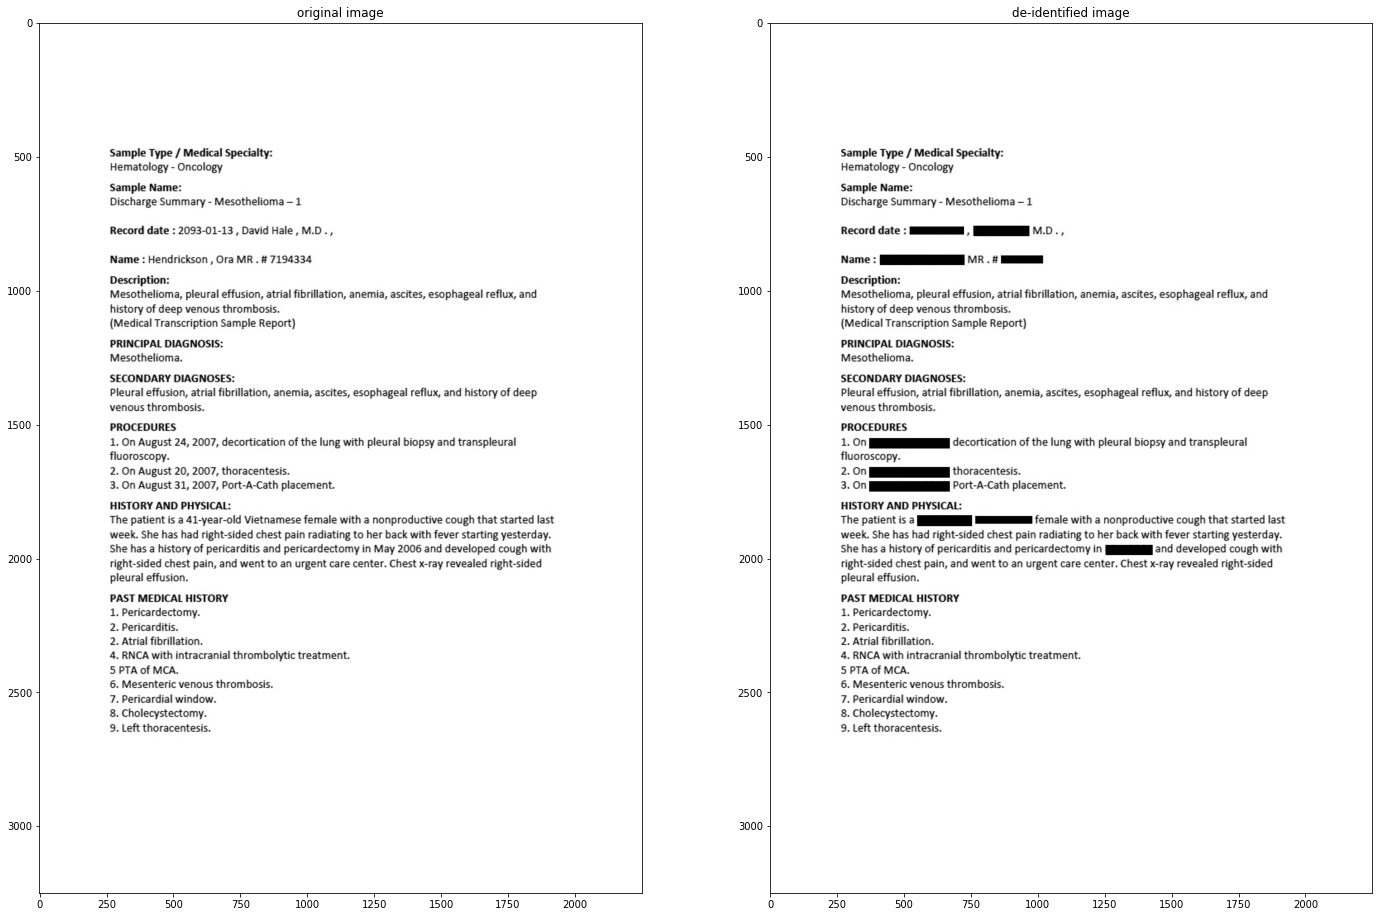

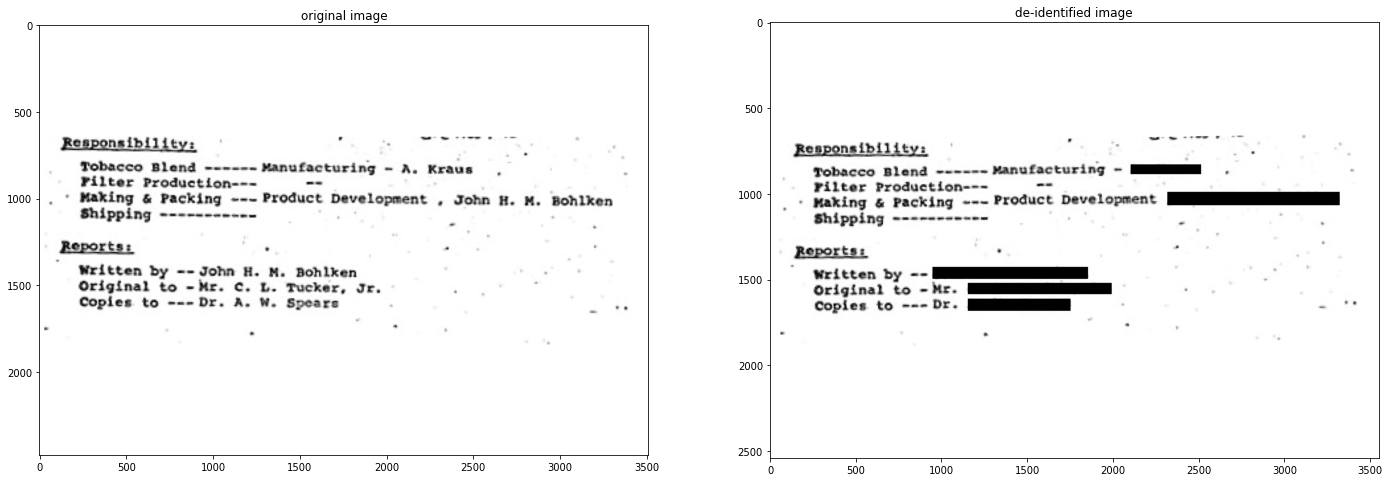

In [0]:
import matplotlib.pyplot as plt
from IPython.display import Image 
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification", "en", "clinical/models")

for row in [0,2]:

  text = ocr_result.select('text').collect()[row][0]

  hocr =  ocr_result.select('hocr').collect()[row][0]

  ner_result = deid_pipeline.fullAnnotate(text)

  ent_dict_list = [{'begin':x.begin, 'end':x.end, 'chunk':x.result, 'ner_label':x.metadata['entity'], 'sentence_id':x.metadata['sentence']} for x in ner_result[0]['ner_chunk']]

  coord_df = get_coordinates_frame(ent_dict_list, text, hocr)
  
  img_deid = ocr_result.select('image_raw').collect()[row][0]
  img_pil_orig = to_pil_image(img_deid, img_deid.mode)
  img_deid = ocr_result.select('corrected_image').collect()[row][0]
  img_pil_deid = to_pil_image(img_deid, img_deid.mode)

  draw_comparisons(img_pil_orig, img_pil_deid, coord_df)

Our pipeline drew black strips over the PHI entities succesfully.

## 6. Extracting and Hiding PHI Entities on DICOM images

If you have a large dicom image dataset, you can take your dataset into delta tabel and read from there by using this script:

```
dicom_df = spark.read.format("delta").load("/mnt/delta/dicom_samples")
```

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  -P /dbfs/FileStore/HLS/dicom/
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -P /dbfs/FileStore/HLS/dicom/

In [0]:
file_path='/FileStore/HLS/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(file_path).sort('path')

print("Number of files in the folder : ", dicom_df.count())

Number of files in the folder : 2

We can convert Dicom images to image by **`DicomToImage`**.

In [0]:
dicomToImage = DicomToImage() \
  .setInputCol("content") \
  .setOutputCol("image") \
  .setMetadataCol("meta")

data = dicomToImage.transform(dicom_df)

display(data)

image,meta,exception,path,modificationTime,length,pagenum
"List(dbfs:/FileStore/HLS/dicom/deidentify-brains-front-medical-3.dcm, 841, 1520, 1, 10, 0, AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA= (truncated))","{ ""00020001"": { ""vr"": ""OB"", ""InlineBinary"": ""AAE="" }, ""00020002"": { ""vr"": ""UI"", ""Value"": [ ""2.25.324227860973032955003270142769571823751"" ] }, ""00020003"": { ""vr"": ""UI"", ""Value"": [ ""2.25.140827433504838727383120953815684045703"" ] }, ""00020010"": { ""vr"": ""UI"", ""Value"": [ ""1.2.840.10008.1.2.1"" ] }, ""00020012"": { ""vr"": ""UI"", ""Value"": [ ""1.2.40.0.13.1.3"" ] }, ""00020013"": { ""vr"": ""SH"", ""Value"": [ ""dcm4che-1.4.0rc1"" ] }, ""00100010"": { ""vr"": ""PN"", ""Value"": [ { ""Alphabetic"": ""Peter Maxime"" } ] }, ""00100020"": { ""vr"": ""LO"", ""Value"": [ ""MF-0000013"" ] }, ""00100030"": { ""vr"": ""DA"", ""Value"": [ ""19500704"" ] }, ""00100040"": { ""vr"": ""CS"", ""Value"": [ ""M"" ] }, ""00101010"": { ""vr"": ""AS"", ""Value"": [ ""075Y"" ] }, ""00101030"": { ""vr"": ""DS"", ""Value"": [ 75.0 ] }, ""00280002"": { ""vr"": ""US"", ""Value"": [ 1 ] }, ""00280004"": { ""vr"": ""CS"", ""Value"": [ ""MONOCHROME2"" ] }, ""00280008"": { ""vr"": ""IS"", ""Value"": [ 3 ] }, ""00280010"": { ""vr"": ""US"", ""Value"": [ 841 ] }, ""00280011"": { ""vr"": ""US"", ""Value"": [ 1520 ] }, ""00280100"": { ""vr"": ""US"", ""Value"": [ 8 ] }, ""00280101"": { ""vr"": ""US"", ""Value"": [ 8 ] }, ""00280102"": { ""vr"": ""US"", ""Value"": [ 7 ] }, ""00280103"": { ""vr"": ""US"", ""Value"": [ 0 ] }, ""7FE00010"": { ""vr"": ""OB"", ""BulkDataURI"": ""pixeldata://?offset=394&length=1278320"" } }",,dbfs:/FileStore/HLS/dicom/deidentify-brains-front-medical-3.dcm,2021-07-14T19:39:20.000+0000,3836142,0
"List(dbfs:/FileStore/HLS/dicom/deidentify-brains-front-medical-3.dcm, 841, 1520, 1, 10, 0, AgABAE9CAAACAAAAAAECAAIAVUksADIuMjUuMzI0MjI3ODYwOTczMDMyOTU1MDAzMjcwMTQyNzY5NTcxODIzNzUxAgADAFVJLAAyLjI1LjE0MDgyNzQzMzUwNDgzODcyNzM4MzEyMDk1MzgxNTY4NDA0NTcwMwIAEABVSRQAMS4= (truncated))","{ ""00020001"": { ""vr"": ""OB"", ""InlineBinary"": ""AAE="" }, ""00020002"": { ""vr"": ""UI"", ""Value"": [ ""2.25.324227860973032955003270142769571823751"" ] }, ""00020003"": { ""vr"": ""UI"", ""Value"": [ ""2.25.140827433504838727383120953815684045703"" ] }, ""00020010"": { ""vr"": ""UI"", ""Value"": [ ""1.2.840.10008.1.2.1"" ] }, ""00020012"": { ""vr"": ""UI"", ""Value"": [ ""1.2.40.0.13.1.3"" ] }, ""00020013"": { ""vr"": ""SH"", ""Value"": [ ""dcm4che-1.4.0rc1"" ] }, ""00100010"": { ""vr"": ""PN"", ""Value"": [ { ""Alphabetic"": ""Peter Maxime"" } ] }, ""00100020"": { ""vr"": ""LO"", ""Value"": [ ""MF-0000013"" ] }, ""00100030"": { ""vr"": ""DA"", ""Value"": [ ""19500704"" ] }, ""00100040"": { ""vr"": ""CS"", ""Value"": [ ""M"" ] }, ""00101010"": { ""vr"": ""AS"", ""Value"": [ ""075Y"" ] }, ""00101030"": { ""vr"": ""DS"", ""Value"": [ 75.0 ] }, ""00280002"": { ""vr"": ""US"", ""Value"": [ 1 ] }, ""00280004"": { ""vr"": ""CS"", ""Value"": [ ""MONOCHROME2"" ] }, ""00280008"": { ""vr"": ""IS"", ""Value"": [ 3 ] }, ""00280010"": { ""vr"": ""US"", ""Value"": [ 841 ] }, ""00280011"": { ""vr"": ""US"", ""Value"": [ 1520 ] }, ""00280100"": { ""vr"": ""US"", ""Value"": [ 8 ] }, ""00280101"": { ""vr"": ""US"", ""Value"": [ 8 ] }, ""00280102"": { ""vr"": ""US"", ""Value"": [ 7 ] }, ""00280103"": { ""vr"": ""US"", ""Value"": [ 0 ] }, ""7FE00010"": { ""vr"": ""OB"", ""BulkDataURI"": ""pixeldata://?offset=394&length=1278320"" } }",,dbfs:/FileStore/HLS/dicom/deidentify-brains-front-medical-3.dcm,2021-07-14T19:39:20.000+0000,3836142,1
"List(dbfs:/FileStore/HLS/dicom/deidentify-brains-front-medical-3.dcm, 841, 1520, 1, 10, 0, AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA= (truncated))","{ 

Let's see the images.

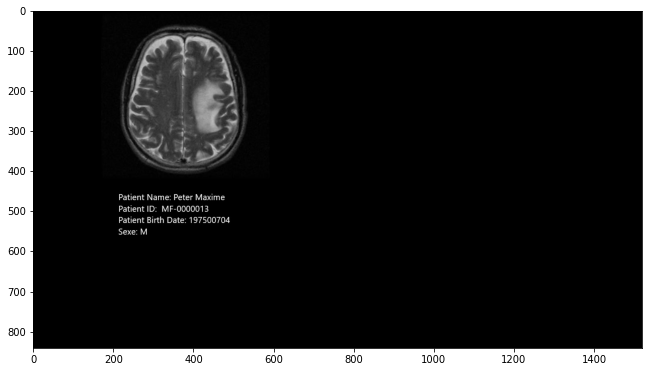

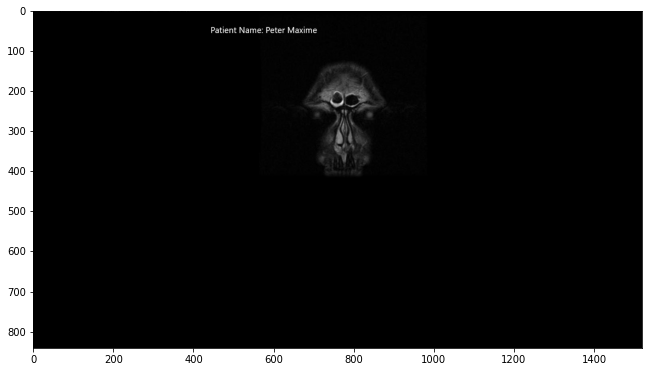

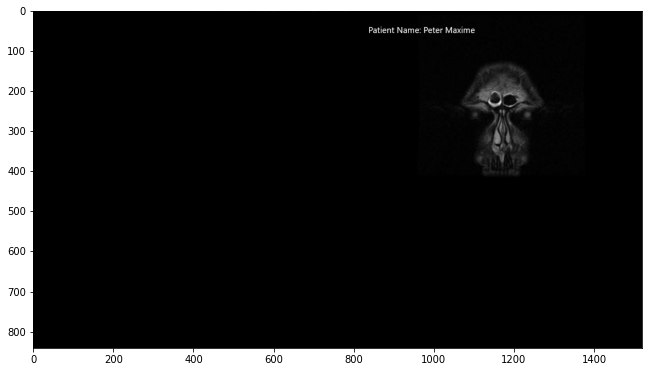

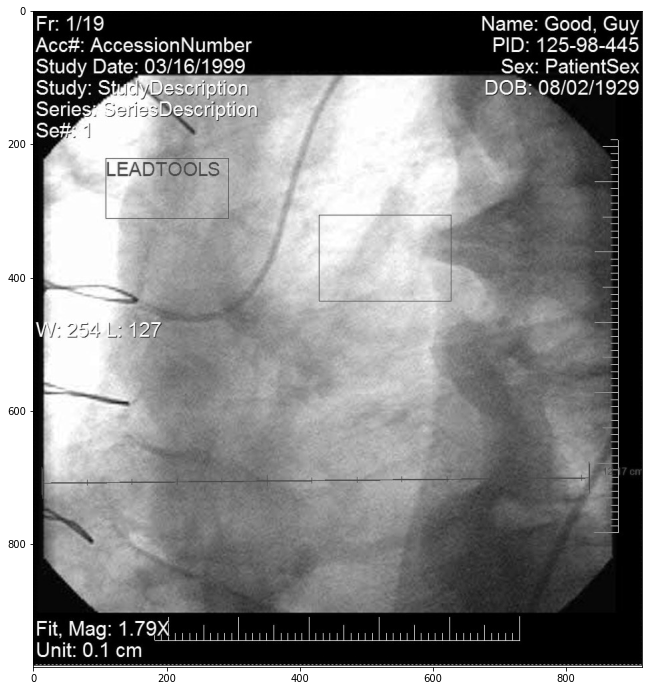

In [0]:
for r in data.select("image").collect():
    img = r.image
    img_pil = to_pil_image(img, img.mode)
    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil, cmap='gray')

Now, we will create a pipeline which converts dicom files to images, extracts text and deidentify PHI entities.

In [0]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")
 
    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")
 
    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")
 
    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")
 
    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON']) #You can set the whitelist accordingly
 
    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

In [0]:
# Read dicom as image
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

adaptive_thresholding = ImageAdaptiveThresholding() \
    .setInputCol("image_raw") \
    .setOutputCol("corrected_image") \
    .setBlockSize(47) \
    .setOffset(4) \
    .setKeepInput(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text")

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(100) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") 
    
# OCR pipeline
deid_pipeline = PipelineModel(stages=[
    dicom_to_image,
    adaptive_thresholding,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions,
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][OK!]

Let's transform the dataframe and see the extracted text.

In [0]:
deid_results = deid_pipeline.transform(dicom_df).cache()

display(deid_results.select("text"))

text
Patient Name: Peter Maxime Patient ID: MF-0000013 Patient Birth Date: 197500704
Patient Name: Peter Maxime
Patient Name: Peter Maxime
"Name: Good, Guy PID: 125-98-445 Sex: PatientSex 08/02/1929 LEAD Unit: 0.1 ¢"


Now we can see original and deidentified images side by side.

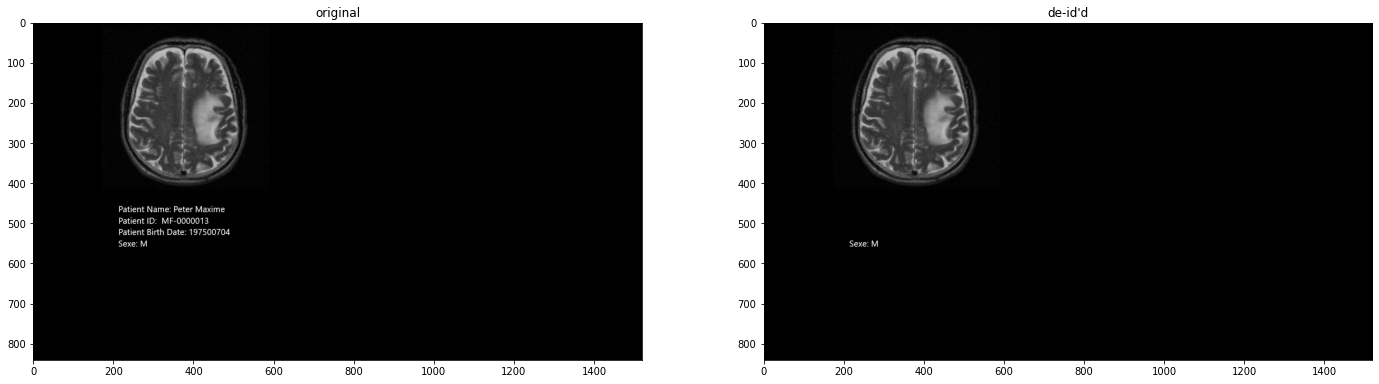

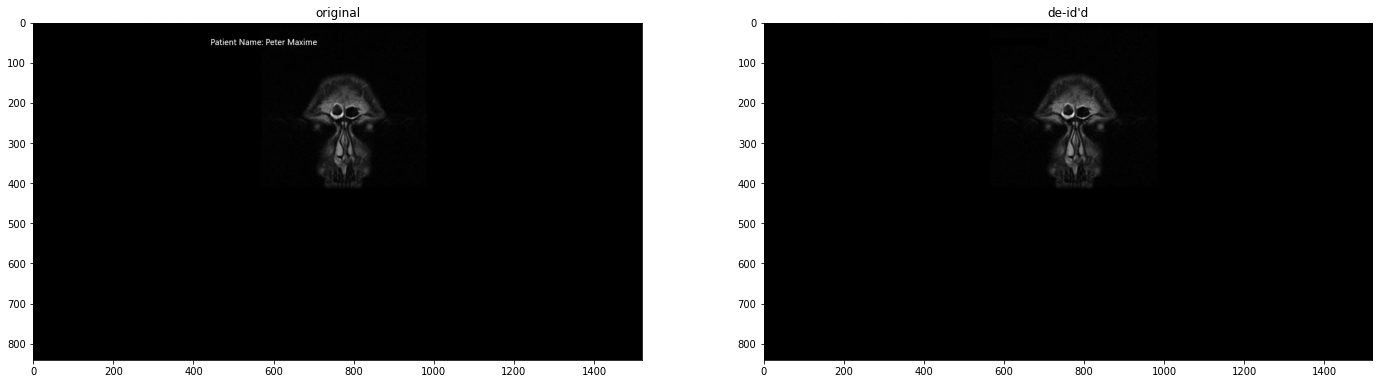

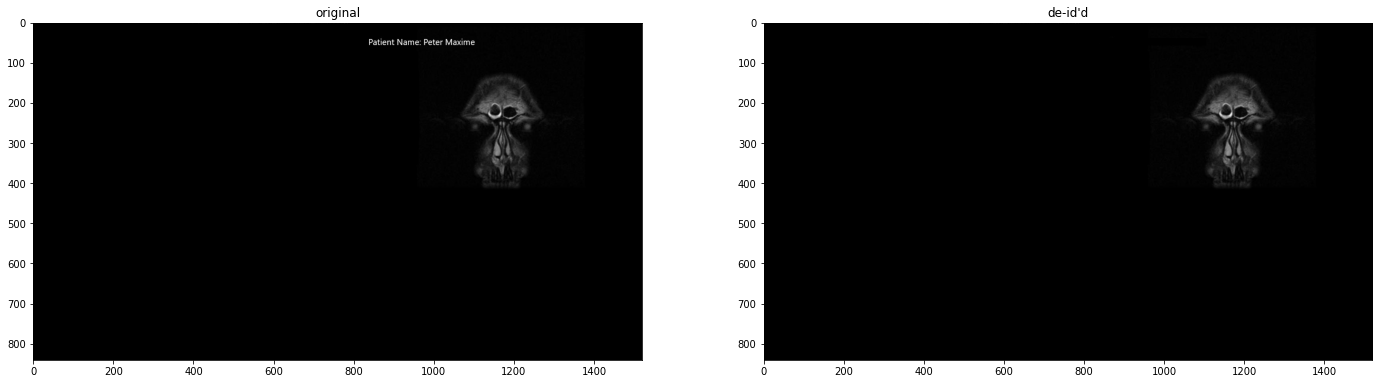

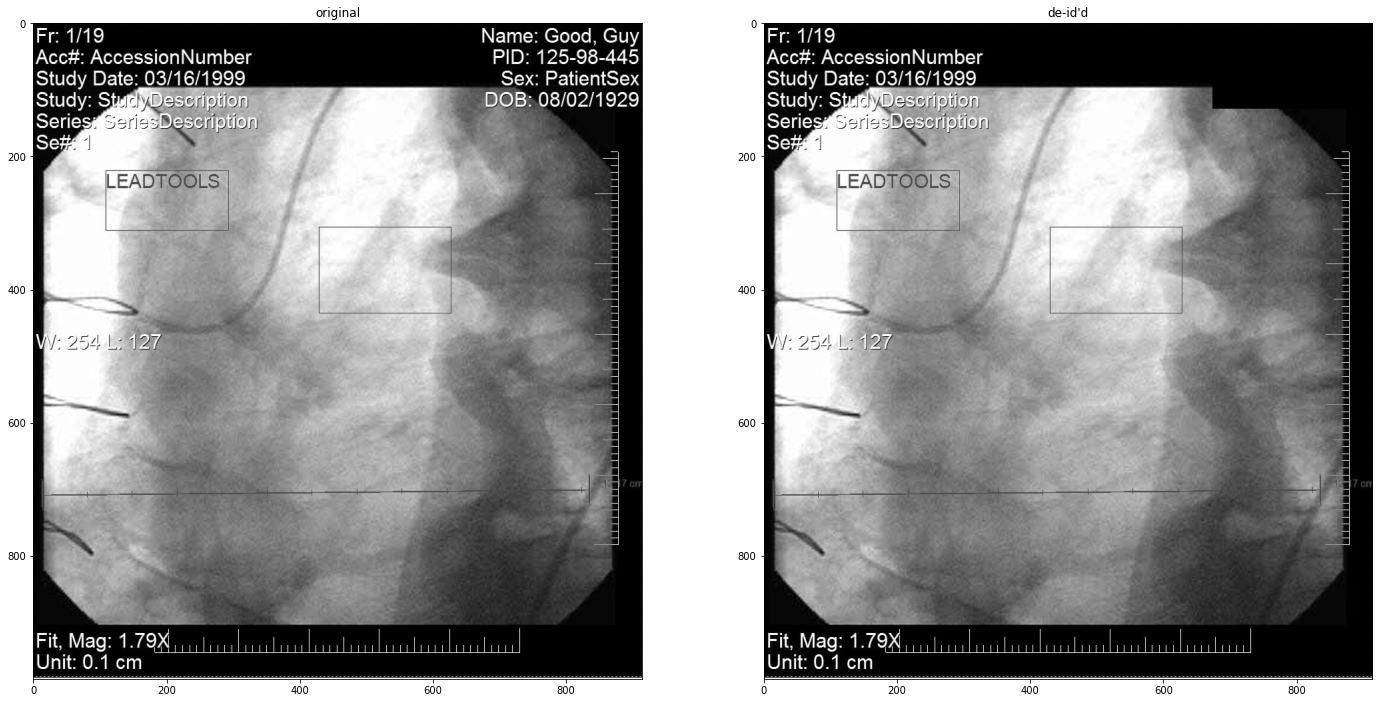

In [0]:
for r in deid_results.select("image_raw", "image_with_regions").collect():
  img_orig = r.image_raw
  img_deid = r.image_with_regions

  img_pil_orig = to_pil_image(img_orig, img_orig.mode)
  img_pil_deid = to_pil_image(img_deid, img_deid.mode)

  plt.figure(figsize=(24,16))
  plt.subplot(1, 2, 1)
  plt.imshow(img_pil_orig, cmap='gray')
  plt.title('original')
  plt.subplot(1, 2, 2)
  plt.imshow(img_pil_deid, cmap='gray')
  plt.title("de-id'd")
  plt.show()